In [43]:
import cv2
import numpy as np
from PIL import Image
import csv

import os
import json

import torch
import torch.nn as nn
import torchvision.models as models

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from sklearn.metrics import r2_score
import pandas as pd

# Data Loading and Preprocessing

In [2]:
def preprocess_image(image_path, target_size=(3840, 2160)):
    # Load the original image
    image = Image.open(image_path).convert('RGB')

    # Resize the image to the target dimensions (3840x2160)
    image = image.resize(target_size, Image.ANTIALIAS)

    # Convert the image to a numpy array and normalize
    image_array = np.array(image) / 255.0  # Normalize to [0, 1]

    return image_array

In [3]:
def preprocess_heatmap(heatmap_path):
    # Assuming grayscale heatmap
    heatmap = cv2.imread(heatmap_path, cv2.IMREAD_GRAYSCALE)
    heatmap = heatmap / 255.0  # Normalize to [0, 1]

    # Convert grayscale heatmap to 3D by adding a channel dimension
    heatmap = np.expand_dims(heatmap, axis=-1)

    return heatmap

In [4]:
def create_combined_input(image_array, heatmap_array):
    # Ensure image_array and heatmap_array have the same dimensions
    if image_array.shape[:2] != heatmap_array.shape[:2]:
        raise ValueError(
            "Image and heatmap must have the same spatial dimensions")

    # Stack the image (3 channels) and heatmap (1 channel) into a 4-channel input
    combined_input = np.concatenate([image_array, heatmap_array], axis=-1)

    return combined_input

In [5]:
# load training labels from csv as dict
def load_labels_from_csv(csv_path):
    labels = {}
    with open(csv_path, 'r') as f:
        reader = csv.reader(f)
        for row in reader:
            labels[row[0]] = row[1]
    return labels

In [6]:
# train_labels = load_labels_from_csv('./data_full/filtered_train_labels_reduced.csv')
# val_labels = load_labels_from_csv('./data_full/validation_labels.csv')
combined_labels = load_labels_from_csv('./data_full/filtered_train_labels.csv')
test_labels = load_labels_from_csv('./data_full/test_labels.csv')

Below is to fix the DataFrames from csv to measurement feature format

In [56]:
# df = pd.read_csv('./good_data/data/test_processed.csv')

In [57]:
# df.head()

,Pothole number,width_mm,height_mm,area_mm2,aspect_ratio,depth_mm,avg_intensity,intensity_range,intensity_std,severity_index,depth_area_interaction,depth_width_interaction,depth_height_interaction,Bags used
0,103,0.562042,0.397217,0.298381,0.267583,0.663934,0.459542,0.663934,0.494798,0.145074,0.215819,0.437546,0.331561,NaN
1,104,0.572546,0.173004,0.174225,0.593524,0.893443,0.702520,0.893443,0.742875,0.164402,0.181747,0.596370,0.275671,NaN
2,105,0.489001,0.458246,0.300131,0.178247,1.000000,0.444247,1.000000,0.951759,0.330843,0.326775,0.600077,0.551334,NaN
3,108,0.270496,0.087696,0.067384,0.451608,0.459016,0.614842,0.459016,0.302400,0.021065,0.045327,0.194506,0.108300,NaN
4,114,0.381871,0.256768,0.163278,0.280154,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN


In [58]:
# Pothole number from int to string and add p in front and .jpg at the end
# df['Pothole number'] = df['Pothole number'].apply(lambda x: 'p' + str(x) + '.jpg')

In [59]:
# df.index = df['Pothole number']

In [60]:
# df.drop(columns=['Pothole number'], inplace=True)

In [61]:
# df.to_json('./good_data/data/test_processed.json', orient='index')

In [13]:
class PotholeDataset(Dataset):
    def __init__(self, image_dir, heatmap_dir, measurement_features_file, labels, transform=None):
        self.image_dir = image_dir
        self.heatmap_dir = heatmap_dir
        self.transform = transform
        self.labels = labels

        # Load measurement features from JSON
        with open(measurement_features_file, 'r') as f:
            self.measurement_features = json.load(f)

        # List all image filenames
        self.image_filenames = list(self.measurement_features.keys())

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_filename = self.image_filenames[idx]

        # Load the raw image
        image_path = os.path.join(self.image_dir, image_filename)
        image = Image.open(image_path).convert('RGB')

        # Load the heatmap
        heatmap_path = os.path.join(self.heatmap_dir, image_filename.replace('.jpg', '.png'))
        heatmap = Image.open(heatmap_path).convert('L')  # Load as grayscale

        # Apply transformations
        if self.transform:
            image = self.transform(image)
            heatmap = self.transform(heatmap)

        # Load the measurement features
        measurement_features = torch.tensor(
            list(self.measurement_features[image_filename].values())[:-1], dtype=torch.float32)
        
        # all_features = torch.tensor(np.array([torch.tensor(list(
        #     self.measurement_features[i].values()), dtype=torch.float32) for i in self.measurement_features.keys()]))

        # means = torch.mean(all_features, axis=0)
        # stds = torch.std(all_features, axis=0)
        
        # Normalize the measurement features (if needed)
        # if sum(measurement_features) != 0:
        #     measurement_features = (measurement_features - means) / stds

        # Combine image and heatmap into a 4-channel tensor
        combined_input = torch.cat((image, heatmap), dim=0)

        if self.labels==test_labels:
            target = torch.nan
        else:
            target = torch.tensor(float(self.labels[image_filename[1:-4]]))

        return combined_input, measurement_features, target

In [14]:
data_transforms = transforms.Compose([
    transforms.Resize((1920, 1080)),
    transforms.ToTensor(),
])

In [15]:
# Create datasets
# train_dataset = PotholeDataset(
#     image_dir='./data/images/train',
#     heatmap_dir='./data/heatmaps/train',
#     measurement_features_file='./data/train_processed.json',
#     labels=train_labels,
#     transform=data_transforms
# )

# val_dataset = PotholeDataset(
#     image_dir='./data/images/val',
#     heatmap_dir='./data/heatmaps/val',
#     measurement_features_file='./data/val_processed.json',
#     labels=val_labels,
#     transform=data_transforms
# )

combined_dataset = PotholeDataset(
    image_dir='./data/images/combined',
    heatmap_dir='./data/heatmaps/combined',
    measurement_features_file='./data/combined_processed.json',
    labels=combined_labels,
    transform=data_transforms
)

test_dataset = PotholeDataset(
    image_dir='./data/images/test',
    heatmap_dir='./data/heatmaps/test',
    measurement_features_file='./data/test_processed.json',
    labels=test_labels,
    transform=data_transforms
)

In [16]:
# Create DataLoader objects
# train_loader = DataLoader(train_dataset, batch_size=32,
#                           shuffle=False, num_workers=4)
# val_loader = DataLoader(val_dataset, batch_size=32,
#                         shuffle=False, num_workers=4)
combined_loader = DataLoader(combined_dataset, batch_size=32,
                             shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32,
                         shuffle=False, num_workers=4)

In [17]:
from torch.utils.data import random_split

# Define the sizes of the training and validation sets
train_size = int(0.8 * len(combined_dataset))
val_size = len(combined_dataset) - train_size

# Split the combined dataset into training and validation sets
train_dataset, val_dataset = random_split(combined_dataset, [train_size, val_size])

# Create DataLoader objects for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

# CNN Construction

In [18]:
# class PotholeDepthEstimator(nn.Module):
#     def __init__(self, num_measurement_features=4):
#         super(PotholeDepthEstimator, self).__init__()

#         # Load a pre-trained ResNet model
#         self.resnet = models.resnet50(pretrained=True)

#         # Adjust the input layer to accept 4 channels (3 for RGB + 1 for heatmap)
#         self.resnet.conv1 = nn.Conv2d(4, 64, kernel_size=(
#             7, 7), stride=(2, 2), padding=(3, 3), bias=False)

#         # Replace the final fully connected layer to output a single value (regression)
#         # self.resnet.fc = nn.Linear(
#         #     self.resnet.fc.in_features + num_measurement_features, 1)

#         # FC layer to process measurement features
#         self.measurement_fc = nn.Linear(num_measurement_features, 32)

#         # Adjust the final fully connected layer to handle the concatenated input
#         self.resnet.fc = nn.Linear(self.resnet.fc.in_features + 32, 1)

#     def forward(self, x, measurement_features):
#         # Pass the combined input through the CNN
#         x = self.resnet(x)

#         # Pass the measurement features through a FC layer
#         measurement_features = self.measurement_fc(measurement_features)

#         # Concatenate the CNN output with the measurement features
#         x = torch.cat([x, measurement_features], dim=0)

#         # Final regression output
#         output = self.resnet.fc(x)

#         return output

In [19]:
class PotholeDepthEstimator(nn.Module):
    def __init__(self, num_measurement_features=12):
        super(PotholeDepthEstimator, self).__init__()

        # Load a pre-trained ResNet-152 model
        self.resnet = models.resnet152(pretrained=True)

        # Adjust the input layer to accept 4 channels (3 for RGB + 1 for heatmap)
        self.resnet.conv1 = nn.Conv2d(
            4, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Freeze most of the ResNet layers
        for param in list(self.resnet.parameters())[:-2]:
            param.requires_grad = False

        # Remove the final fully connected layer
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-1])

        # FC layer to process measurement features
        self.measurement_fc = nn.Linear(num_measurement_features, 64)

        # New fully connected layers for combined features
        self.fc_combined = nn.Sequential(
            nn.Linear(2048 + 64, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Flatten(0, -1)  # Flatten the last dimension
        )

    def forward(self, x, measurement_features):
        # Pass the combined input through the CNN
        x = self.resnet(x)
        x = torch.flatten(x, 1)

        # Pass the measurement features through a FC layer
        measurement_features = self.measurement_fc(measurement_features)

        # Concatenate the CNN output with the measurement features
        combined = torch.cat([x, measurement_features], dim=1)

        # Final regression output
        output = self.fc_combined(combined)

        return output

In [20]:
model = PotholeDepthEstimator().cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

/home/deanbrand/Projects/SBH2024/RegressionLoop/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/deanbrand/Projects/SBH2024/RegressionLoop/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [21]:
num_epochs = 750
train_losses = []
val_losses = []

In [22]:
# Debugging the Dataset
dataset = PotholeDataset(
    image_dir='./data/images/combined/',
    heatmap_dir='./data/heatmaps/combined/',
    measurement_features_file='./data/combined_processed.json',
    labels=combined_labels,
    transform=data_transforms
)

# Test loading a single item
# Load the first item
combined_input, measurement_features, target = dataset[2]

print(f"Combined Input Shape: {combined_input.shape}")
print(f"Measurement Features: {measurement_features}")
print(f"Target: {target}")

Combined Input Shape: torch.Size([4, 1920, 1080])
Measurement Features: tensor([0.0299, 0.0337, 0.0010, 0.4731, 1.0000, 0.3081, 1.0000, 0.8032, 0.0010,
        0.0010, 0.0303, 0.0342])
Target: 0.5


In [23]:
# Initialize lists to store R² values for each epoch
train_r2_scores = []
val_r2_scores = []

# Training loop
for epoch in range(num_epochs):
    model.train()

    train_loss = 0
    y_train_true = []
    y_train_pred = []

    for combined_input, measurement_features, targets in train_loader:
        combined_input = combined_input.cuda()
        measurement_features = measurement_features.cuda()
        targets = targets.cuda()

        # Forward pass
        outputs = model(combined_input, measurement_features)

        # Compute loss
        loss = criterion(outputs, targets)
        train_loss += loss.item()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Store true and predicted values for R² calculation
        y_train_true.extend(targets.cpu().numpy().flatten())
        y_train_pred.extend(outputs.cpu().detach().numpy().flatten())

    # Calculate R² for the training set after the epoch
    train_r2 = r2_score(y_train_true, y_train_pred)
    train_r2_scores.append(train_r2)
    print(f'Epoch {epoch+1}, Training R²: {train_r2:.4f}')

    # Normalize train loss by number of batches
    train_losses.append(train_loss / len(train_loader))

    # Validation loop
    model.eval()
    y_val_true = []
    y_val_pred = []
    with torch.no_grad():
        val_loss = 0
        for combined_input, measurement_features, targets in val_loader:
            combined_input = combined_input.cuda()
            measurement_features = measurement_features.cuda()
            targets = targets.cuda()

            # Forward pass
            outputs = model(combined_input, measurement_features)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

            # Store true and predicted values for R² calculation
            y_val_true.extend(targets.cpu().numpy().flatten())
            y_val_pred.extend(outputs.cpu().numpy().flatten())

        # Calculate R² for the validation set after the epoch
        val_r2 = r2_score(y_val_true, y_val_pred)
        val_r2_scores.append(val_r2)
        print(f'Epoch {epoch+1}, Validation R²: {val_r2:.4f}')

        val_loss /= len(val_loader)  # Normalize val loss by number of batches
        val_losses.append(val_loss)
        print(f'Epoch {epoch+1}, Validation Loss: {val_loss:.4f}')
        print()

Epoch 1, Training R²: -0.1036
Epoch 1, Validation R²: -1.9564
Epoch 1, Validation Loss: 0.4784

Epoch 2, Training R²: -0.1089
Epoch 2, Validation R²: -0.3870
Epoch 2, Validation Loss: 0.2139

Epoch 3, Training R²: 0.0337
Epoch 3, Validation R²: -2.1803
Epoch 3, Validation Loss: 0.5115

Epoch 4, Training R²: 0.0670
Epoch 4, Validation R²: -2.6849
Epoch 4, Validation Loss: 0.5959

Epoch 5, Training R²: 0.0024
Epoch 5, Validation R²: 0.0307
Epoch 5, Validation Loss: 0.1381

Epoch 6, Training R²: -0.0434
Epoch 6, Validation R²: -1.0642
Epoch 6, Validation Loss: 0.3255

Epoch 7, Training R²: 0.0986
Epoch 7, Validation R²: -1.3688
Epoch 7, Validation Loss: 0.3678

Epoch 8, Training R²: 0.1786
Epoch 8, Validation R²: -0.3790
Epoch 8, Validation Loss: 0.1984

Epoch 9, Training R²: 0.2109
Epoch 9, Validation R²: -0.6153
Epoch 9, Validation Loss: 0.2308

Epoch 10, Training R²: 0.2892
Epoch 10, Validation R²: -1.3518
Epoch 10, Validation Loss: 0.3353

Epoch 11, Training R²: 0.2779
Epoch 11, Valid

In [24]:
# # Training loop
# for epoch in range(num_epochs):
#     model.train()

#     train_loss = 0

#     for combined_input, measurement_features, targets in train_loader:
#         combined_input = combined_input.cuda()
#         measurement_features = measurement_features.cuda()
#         targets = targets.cuda()

#         # Forward pass
#         outputs = model(combined_input, measurement_features)

#         # Compute loss and backpropagate
#         loss = criterion(outputs, targets)
#         train_loss += loss.item()
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
        
#     train_losses.append(train_loss)

#     # Validation loop
#     model.eval()
#     with torch.no_grad():
#         val_loss = 0
#         for combined_input, measurement_features, targets in val_loader:
#             combined_input = combined_input.cuda()
#             measurement_features = measurement_features.cuda()
#             targets = targets.cuda()

#             # Forward pass
#             outputs = model(combined_input, measurement_features)
#             loss = criterion(outputs, targets)
#             val_loss += loss.item()

#         val_loss /= len(val_loader)
#         val_losses.append(val_loss)
#         print(f'Epoch {epoch+1}, Validation Loss: {val_loss:.4f}')

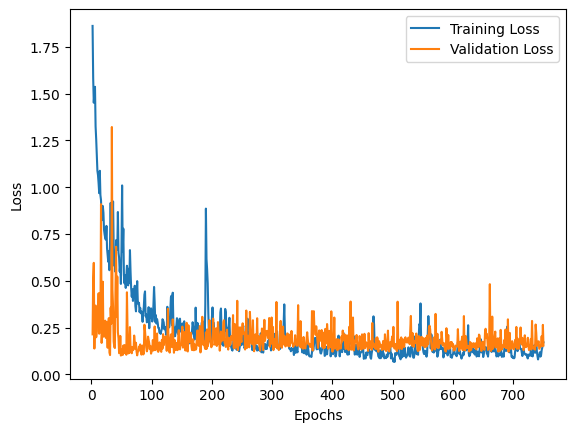

In [25]:
import matplotlib.pyplot as plt

# Assuming you have lists storing loss values per epoch
epochs = range(2, num_epochs + 1)
plt.plot(epochs, train_losses[1:], label='Training Loss')
plt.plot(epochs, val_losses[1:], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [26]:
# Test loop
model.eval()
predictions = []

with torch.no_grad():
    for combined_input, measurement_features, target in test_loader:
        combined_input = combined_input.cuda()
        measurement_features = measurement_features.cuda()

        # Forward pass
        outputs = model(combined_input, measurement_features)
        predictions.extend(outputs.cpu().numpy())

In [27]:
predictions

[np.float32(0.81568),
 np.float32(0.66678643),
 np.float32(0.44736522),
 np.float32(4.9514146),
 np.float32(1.0596786),
 np.float32(0.43775642),
 np.float32(0.43775642),
 np.float32(3.400614),
 np.float32(1.8555684),
 np.float32(2.1269488),
 np.float32(0.48700997),
 np.float32(0.59771514),
 np.float32(0.43775642),
 np.float32(0.7556182),
 np.float32(0.43775642),
 np.float32(1.3025647),
 np.float32(0.47428557),
 np.float32(0.43775642),
 np.float32(0.43775642),
 np.float32(2.6866634),
 np.float32(0.45697966),
 np.float32(0.43775642),
 np.float32(0.5352905),
 np.float32(0.43775642),
 np.float32(0.44918844),
 np.float32(0.43775642),
 np.float32(0.50414276),
 np.float32(0.43775642),
 np.float32(0.43775642),
 np.float32(0.43775642)]

In [28]:
import pandas as pd

In [29]:
preds_df = pd.read_csv('./data_full/test_labels.csv')

In [30]:
preds_df = pd.concat([preds_df['Pothole number'], pd.Series(predictions, name='Bags used')], axis=1)

In [31]:
preds_df

,Pothole number,Bags used
0,103,0.815680
1,104,0.666786
2,105,0.447365
3,108,4.951415
4,114,1.059679
5,143,0.437756
6,144,0.437756
7,406,3.400614
8,434,1.855568
9,450,2.126949


In [32]:
preds_df.to_csv('cnn4_preds.csv', index=False)